In [1]:
from __future__ import division

import os
import glob
from collections import defaultdict

import imageio
import numpy as np

from matplotlib import pyplot as plt

from evaluation.bbox_iou import bbox_iou

In [2]:
def size(mask, bbox):
    tly, tlx, bry, brx = bbox
    return np.count_nonzero(mask[tly:bry,tlx:brx])

In [3]:
def form_factor(bbox):
    tly, tlx, bry, brx = bbox
    width = brx - tlx
    height = bry - tly
    return width / height

In [4]:
def filling_ratio(mask, bbox):
    tly, tlx, bry, brx = bbox
    width = brx - tlx
    height = bry - tly
    bbox_area = width * height
    mask_area = size(mask, bbox)
    return mask_area / bbox_area

In [5]:
def compute_num_overlap(gts):
    if len(gts) > 1:
        for i in range(len(gts)):
            bboxA = list(map(float, gts[i][:4]))
            for j in range(i+1, len(gts)):
                bboxB = list(map(float, gts[j][:4]))
                print(img, bbox_iou(bboxA, bboxB))

In [6]:
class_frequency = defaultdict(int)
size_per_class = defaultdict(list)
form_factor_per_class = defaultdict(list)
filling_ratio_per_class = defaultdict(list)
for img in glob.glob('data/train/*.jpg'):
    name = os.path.splitext(os.path.split(img)[1])[0]
    mask_file = 'data/train/mask/mask.{}.png'.format(name)
    gt_file = 'data/train/gt/gt.{}.txt'.format(name)
    mask = imageio.imread(mask_file)
    gts = [line.split(' ') for line in open(gt_file, 'r').read().splitlines()]
    for gt in gts:
        bbox = np.round(list(map(int, map(float, gt[:4]))))
        label = gt[4]
        class_frequency[label] += 1
        size_per_class[label].append(size(mask, bbox))
        form_factor_per_class[label].append(form_factor(bbox))
        filling_ratio_per_class[label].append(filling_ratio(mask, bbox))

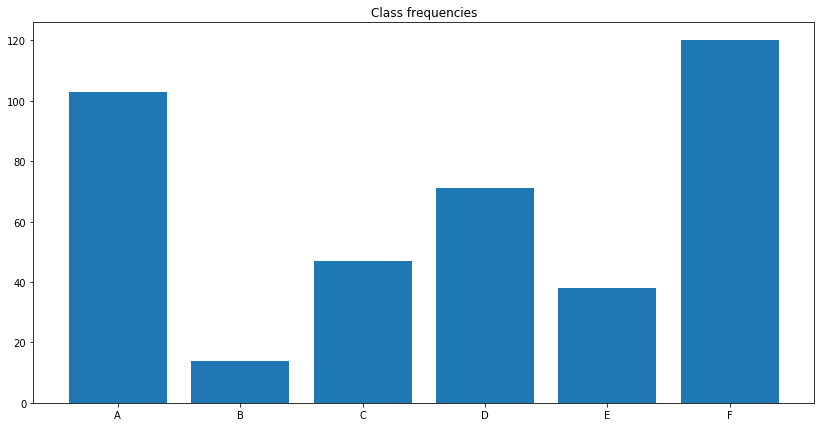

In [7]:
labels = sorted(class_frequency.keys())
frequencies = [class_frequency[label] for label in labels]
ind = range(len(labels))
plt.figure(figsize=(14, 7))
plt.bar(ind, frequencies)
plt.xticks(ind, labels)
plt.title('Class frequencies')
plt.show()

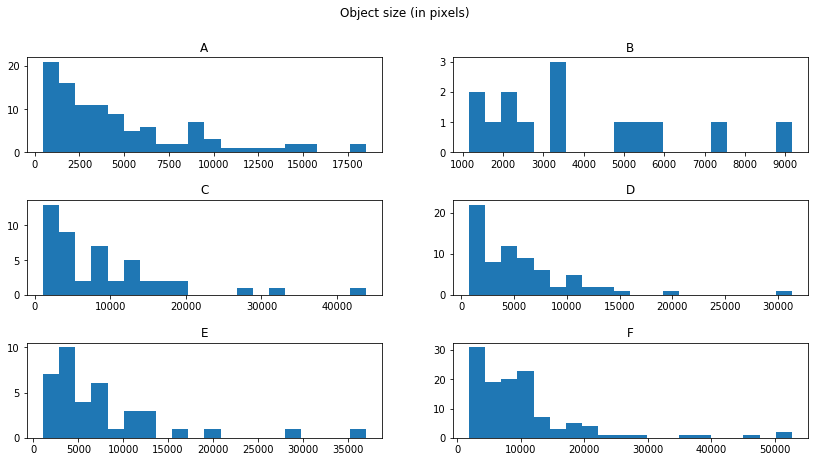

In [8]:
labels = sorted(size_per_class.keys())
nrows = 3
ncols = int(np.ceil(len(labels)/nrows))
fig, ax = plt.subplots(nrows, ncols, figsize=(14, 7))
for idx, label in enumerate(labels):
    i, j = idx//ncols, idx%ncols
    ax[i, j].hist(size_per_class[label], bins=20)
    ax[i, j].set_title(label)
    fig.subplots_adjust(hspace=0.5)
fig.suptitle('Object size (in pixels)')
plt.show()